## 파생변수 생성

수익 증대를 위한 마케팅 관점에서 고객을 클러스터링 할 수 있는 파생변수를 생성

1. 평균 할인율
2. 구매 카테고리 다양성
3. Total_수량(고객별 전체 제품 구매수량)
4. Average_Unit_Price(고객별 제품당 평균 구매 금액)
5. 쿠폰사용비율
6. 주말_거래(Onlinesale_info.csv에 날짜 컬럼을 요일과 매칭시켜 주말(토~일)의 거래건수 총합)
7. 평일_거래(Onlinesale_info.csv에 날짜 컬럼을 요일과 매칭시켜 평일(월~금)의 거래건수 총합)
8. 고가제품 구매율

In [11]:
import pandas as pd

# 1. 데이터 로드
customer_df = pd.read_csv(r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Customer_info.csv")
discount_df = pd.read_csv(r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Discount_info.csv")
onlinesales_df = pd.read_csv(r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv")

# 2. onlinesales_df 전처리: 날짜 컬럼 처리
onlinesales_df['거래날짜'] = pd.to_datetime(onlinesales_df['거래날짜'])
# 할인정보 병합에 필요한 월 추출 (예: Jan, Feb 등)
onlinesales_df['월'] = onlinesales_df['거래날짜'].dt.strftime('%b')
# 요일 정보 (월~일: 0~6; 주말은 5,6)
onlinesales_df['거래요일'] = onlinesales_df['거래날짜'].dt.dayofweek

# 3. 파생변수 1: 평균 할인율
# 할인_df와 onlinesales_df를 (월, 제품카테고리) 기준으로 병합
onlinesales_with_discount = pd.merge(onlinesales_df, discount_df, on=['월', '제품카테고리'], how='left')
# 고객별 할인율 평균 계산
avg_discount_df = onlinesales_with_discount.groupby('고객ID')['할인율'].mean().reset_index()
avg_discount_df.rename(columns={'할인율': '평균할인율'}, inplace=True)
# 할인율 결측치 (할인정보가 없는 거래)는 0으로 처리
avg_discount_df['평균할인율'] = avg_discount_df['평균할인율'].fillna(0)

# 4. 파생변수 2: 구매 카테고리 다양성
# 고객별 구매한 제품카테고리의 고유 개수 계산
cat_diversity_df = onlinesales_df.groupby('고객ID')['제품카테고리'].nunique().reset_index()
cat_diversity_df.rename(columns={'제품카테고리': '구매_카테고리_다양성'}, inplace=True)

# 5. 파생변수 3: Total_수량 (고객별 전체 구매수량)
total_quantity_df = onlinesales_df.groupby('고객ID')['수량'].sum().reset_index()
total_quantity_df.rename(columns={'수량': 'Total_수량'}, inplace=True)

# 6. 파생변수 4: Average_Unit_Price (고객별 제품당 평균 구매 금액)
# 단, 구매 금액이 제품별 가격이므로 고객별 구매한 전체 금액을 총 수량으로 나누어 계산 (가중평균)
avg_unit_price_df = onlinesales_df.groupby('고객ID').apply(
    lambda df: (df['평균금액'] * df['수량']).sum() / df['수량'].sum()
).reset_index(name='Average_Unit_Price')

# 7. 파생변수 5: 쿠폰사용비율
# 쿠폰상태("Used" vs "Not Used")를 1/0으로 매핑 후 고객별 평균 계산
onlinesales_df['쿠폰사용'] = onlinesales_df['쿠폰상태'].apply(lambda x: 1 if x == 'Used' else 0)
coupon_usage_df = onlinesales_df.groupby('고객ID')['쿠폰사용'].mean().reset_index()
coupon_usage_df.rename(columns={'쿠폰사용': '쿠폰사용비율'}, inplace=True)

# 8. 파생변수 6 & 7: 주말_거래 및 평일_거래
# 주말: 토(5)와 일(6), 평일: 월(0)~금(4)
weekend_df = onlinesales_df[onlinesales_df['거래요일'] >= 5].groupby('고객ID').size().reset_index(name='주말_거래')
weekday_df = onlinesales_df[onlinesales_df['거래요일'] < 5].groupby('고객ID').size().reset_index(name='평일_거래')

# 9. 파생변수 8: 고가제품 구매율
# 전체 거래에서 '평균금액'이 상위 25% 이상인 제품을 고가 제품으로 정의
high_price_threshold = onlinesales_df['평균금액'].quantile(0.75)
onlinesales_df['고가제품여부'] = onlinesales_df['평균금액'] > high_price_threshold
# 고객별 고가 제품 구매 비율 계산 (True를 1로 취급)
high_price_df = onlinesales_df.groupby('고객ID')['고가제품여부'].mean().reset_index()
high_price_df.rename(columns={'고가제품여부': '고가제품구매율'}, inplace=True)

# 10. customer_df와 파생변수 병합
# 순차적으로 고객ID를 기준으로 left merge (고객 거래가 없는 경우 NaN은 이후 0으로 처리)
derived_dfs = [avg_discount_df, cat_diversity_df, total_quantity_df, 
               avg_unit_price_df, coupon_usage_df, weekend_df, weekday_df, high_price_df]

for df in derived_dfs:
    customer_df = pd.merge(customer_df, df, on='고객ID', how='left')

# 거래가 없는 고객의 파생변수 결측치는 0으로 채움
fill_cols = ['평균할인율', '구매_카테고리_다양성', 'Total_수량', 
             'Average_Unit_Price', '쿠폰사용비율', '주말_거래', '평일_거래', '고가제품구매율']
customer_df[fill_cols] = customer_df[fill_cols].fillna(0)

# 최종 결과 확인
print(customer_df.head())

# 결과 저장
customer_df.to_csv(r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가")


        고객ID 성별        고객지역  가입기간      평균할인율  구매_카테고리_다양성  Total_수량  \
0  USER_1358  남     Chicago    12  10.000000           15      1133   
1  USER_0190  남  California    43  22.045455            8       175   
2  USER_0066  남     Chicago    33  15.238095            9       155   
3  USER_0345  여  California    30  10.000000            1         1   
4  USER_0683  남  California    49  23.333333            4        15   

   Average_Unit_Price    쿠폰사용비율  주말_거래  평일_거래   고가제품구매율  
0           30.495499  0.306397   34.0  263.0  0.390572  
1           17.421657  0.409091    0.0   44.0  0.295455  
2           15.235355  0.285714    0.0   42.0  0.095238  
3            1.240000  0.000000    0.0    1.0  0.000000  
4           69.581333  0.333333    1.0    5.0  0.500000  


C:\Users\Jimin\AppData\Local\Temp\ipykernel_19740\4202455121.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_unit_price_df = onlinesales_df.groupby('고객ID').apply(


## 클러스터링

위에서 추가한 파생변수가 들어있는 데이터로 모델별 클러스터링 결과 비교
변수는 생성 가능한 모든 변수 조합의 실루엣 계수를 계산해 그중 가장 높은 조합을 채택하였음.

순서대로 
1. Birch
2. K-Medoids
3. K-Means

실루엣 계수 비교 : K-Means(0.581) > K-Medoids(0.579) > Birch(0.533)

Explained Variance Ratio by PCA: [0.80958295 0.14241392]
Cluster Sizes:
Cluster
1    538
0    519
3    303
2    108
Name: count, dtype: int64


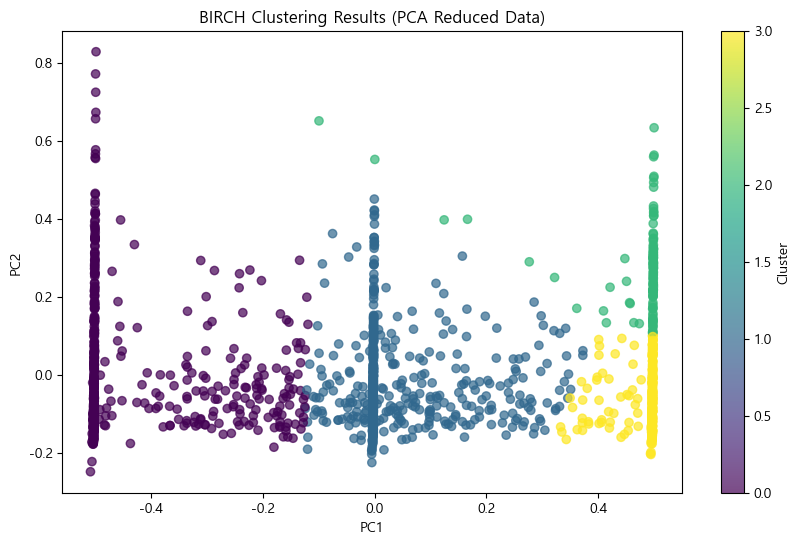

Overall Average Silhouette Score: 0.533
Cluster 0: Average Silhouette Score = 0.463
Cluster 1: Average Silhouette Score = 0.517
Cluster 2: Average Silhouette Score = 0.518
Cluster 3: Average Silhouette Score = 0.687


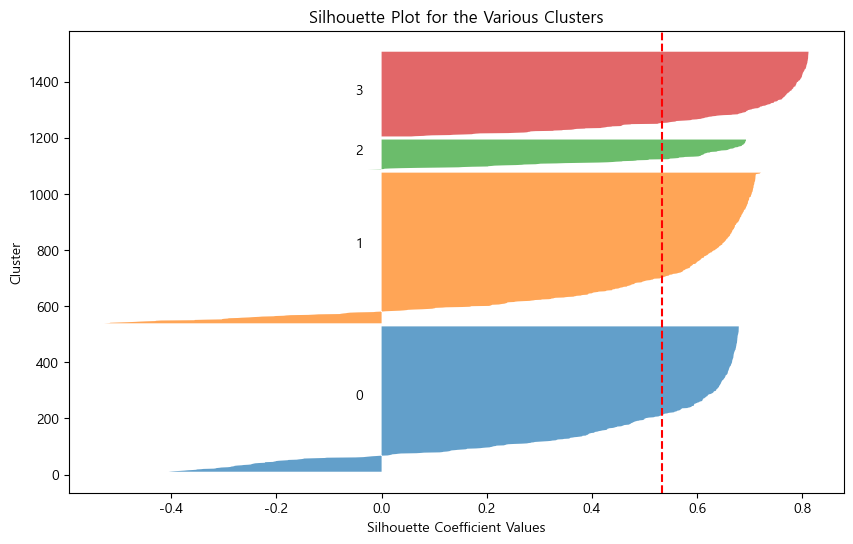


Cluster Summary (Feature Averages):
             평균할인율  Average_Unit_Price    Total_수량    쿠폰사용비율
Cluster                                                     
0        11.541088           37.516022  146.535645  0.717781
1        20.910902           31.386103  219.693309  0.716224
2        29.475741           92.553054   25.685185  0.476048
3        29.743348           22.926778  135.353135  0.753454


<Figure size 1400x800 with 0 Axes>

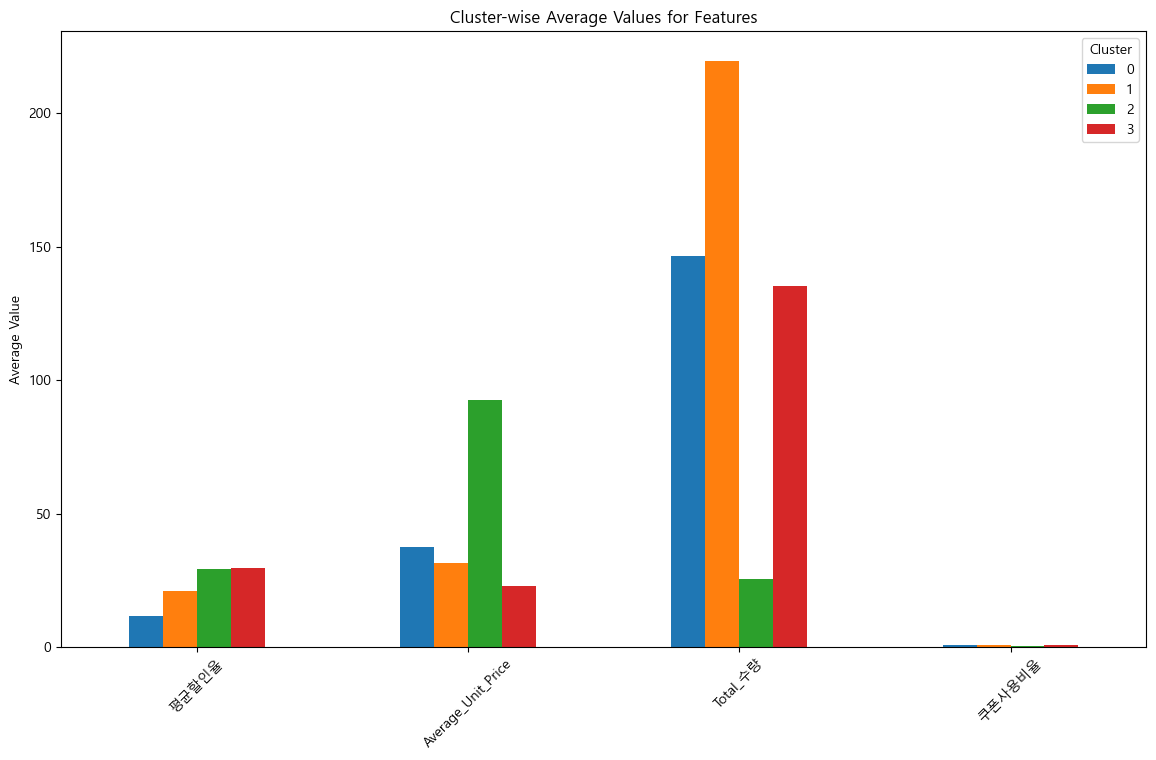

In [42]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import matplotlib.font_manager as fm  
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False  

# matplotlib의 기본 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' 

# 1. 데이터 로드
file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가"
df = pd.read_csv(file_path)

# 2. 숫자형 변수만 선택
data = df[[ '평균할인율', 'Average_Unit_Price', 'Total_수량', '쿠폰사용비율']]

# 3. 데이터 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 4. 차원 축소 (PCA)
pca = PCA(n_components=2)  # 2D로 축소
data_pca = pca.fit_transform(data_scaled)

# PCA 결과 확인
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

# 5. BIRCH 클러스터링
birch_model = Birch(threshold=0.28, n_clusters=None)  # threshold 조정 가능
df['Cluster'] = birch_model.fit_predict(data_pca)

# 클러스터 결과 확인
print("Cluster Sizes:")
print(df['Cluster'].value_counts())

# 6. 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('BIRCH Clustering Results (PCA Reduced Data)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 10. 실루엣 계수 계산
# 클러스터의 개수가 2개 이상일 때만 계산 가능
if len(df['Cluster'].unique()) > 1:
    silhouette_avg = silhouette_score(data_pca, df['Cluster'])
    sample_silhouette_values = silhouette_samples(data_pca, df['Cluster'])
    print(f"Overall Average Silhouette Score: {silhouette_avg:.3f}")
    
    # 클러스터별 실루엣 계수 출력
    for cluster in np.unique(df['Cluster']):
        cluster_silhouette = sample_silhouette_values[df['Cluster'] == cluster]
        print(f"Cluster {cluster}: Average Silhouette Score = {np.mean(cluster_silhouette):.3f}")
    
    # 실루엣 계수 시각화
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(df['Cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[df['Cluster'] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette Plot for the Various Clusters")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")
    plt.show()
else:
    print("Silhouette score cannot be calculated because the number of clusters is less than 2.")


# 7. 군집별 평균값 계산
numeric_columns = data.columns  # 원본 데이터 열 이름
cluster_summary = df.groupby('Cluster')[numeric_columns].mean()

print("\nCluster Summary (Feature Averages):")
print(cluster_summary)

# 8. 군집별 평균값 시각화
plt.figure(figsize=(14, 8))
cluster_summary.T.plot(kind='bar', figsize=(14, 8))
plt.title('Cluster-wise Average Values for Features')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()



In [26]:
!pip install pyclustering

     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ------------------------ --------------- 1.6/2.6 MB 9.3 MB/s eta 0:00:01
     ---------------------------------------- 2.6/2.6 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395198 sha256=82c2e3ce55fec2a12a8c872b3b7488856931f492d9151683de44aa03a786a9b5
  Stored in directory: c:\users\jimin\appdata\local\pip\cache\wheels\68\29\b4\131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


DEPRECATION: Loading egg at c:\users\jimin\anaconda3\lib\site-packages\py_hanspell-1.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


Explained Variance Ratio by PCA: [0.80958295 0.14241392]
Cluster Sizes:
Cluster
3.0    562
0.0    457
2.0    334
1.0    115
Name: count, dtype: int64


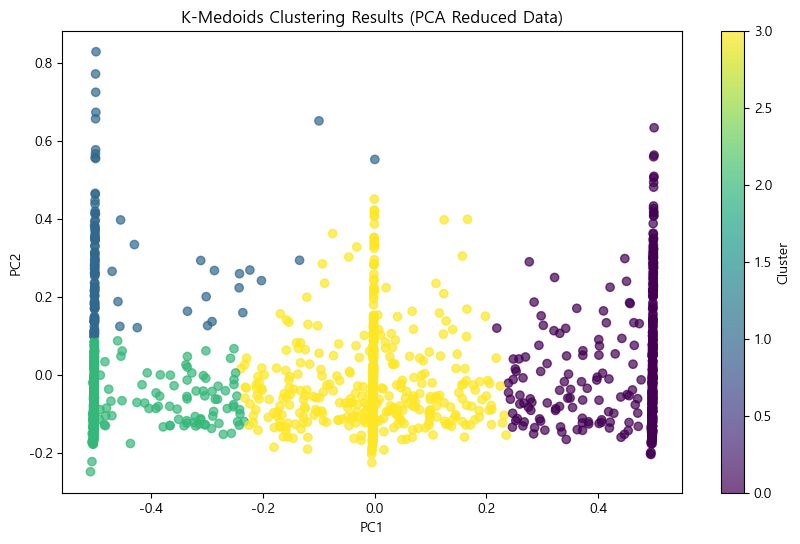

Overall Average Silhouette Score: 0.579
Cluster 0.0: Average Silhouette Score = 0.591
Cluster 1.0: Average Silhouette Score = 0.418
Cluster 2.0: Average Silhouette Score = 0.650
Cluster 3.0: Average Silhouette Score = 0.559


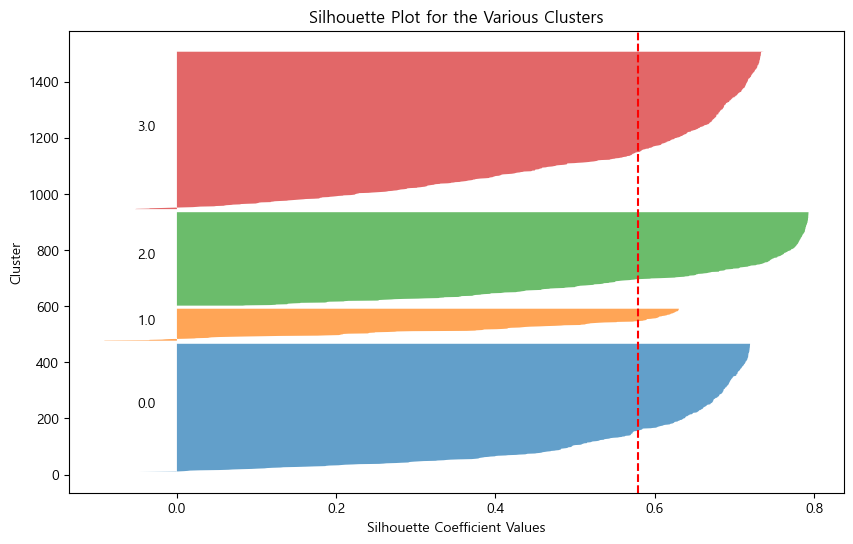


Cluster Summary (Feature Averages):
             평균할인율  Average_Unit_Price    Total_수량    쿠폰사용비율
Cluster                                                     
0.0      29.331807           39.321204  116.350109  0.685018
1.0      10.716951           94.566570   23.930435  0.482923
2.0      10.776741           20.802033  151.389222  0.803343
3.0      19.927024           31.149925  234.065836  0.712920


<Figure size 1400x800 with 0 Axes>

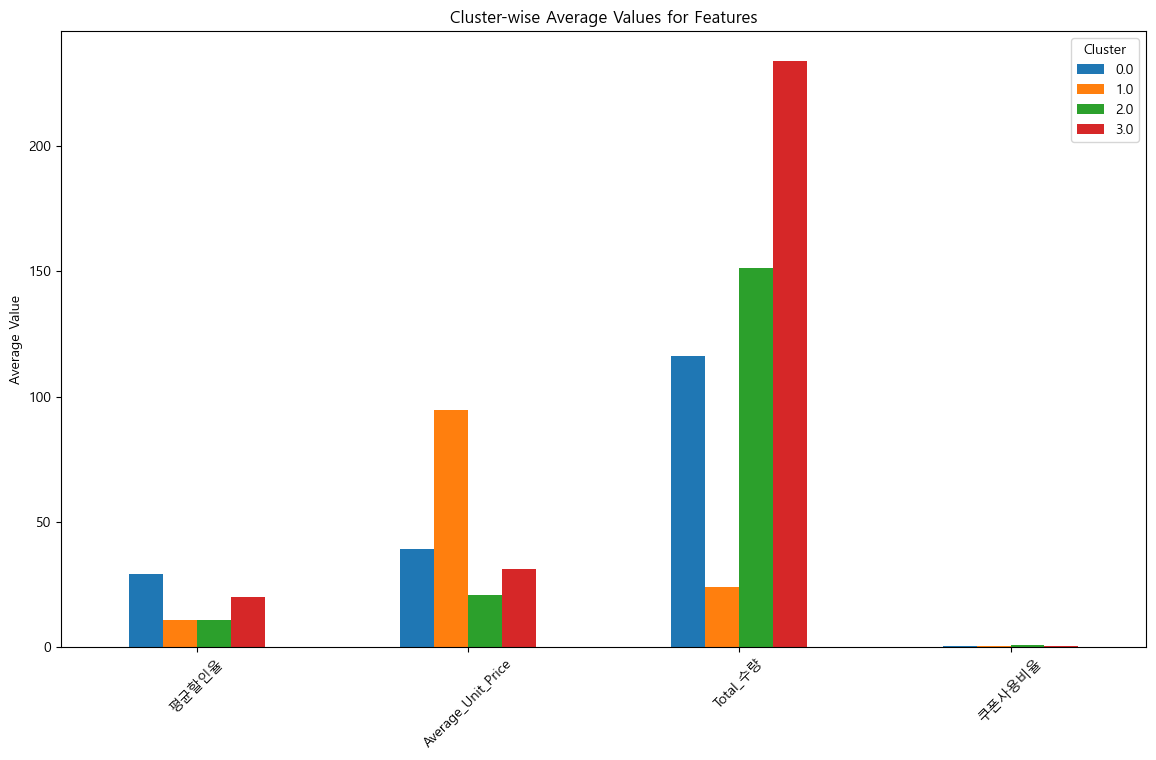

In [44]:
import pandas as pd
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 환경)
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False  

# 1. 데이터 로드
file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가"
df = pd.read_csv(file_path)

# 2. 숫자형 변수만 선택
data = df[['평균할인율', 'Average_Unit_Price', 'Total_수량', '쿠폰사용비율']]

# 3. 데이터 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 4. 차원 축소 (PCA)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# PCA 결과 확인
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

# 5. K-Medoids 클러스터링 수행
# 💡 `kmedoids`는 `n_clusters=4`가 아니라, 초기 메도이드 인덱스를 직접 지정해야 함
np.random.seed(42)  # 랜덤 시드 고정
initial_medoids = np.random.choice(len(data_pca), 4, replace=False)  # 4개의 초기 중심점 선택

# K-Medoids 모델 생성 및 학습
kmedoids_model = kmedoids(data_pca, initial_medoids)
kmedoids_model.process()

# 클러스터 결과 저장
clusters = kmedoids_model.get_clusters()
labels = np.zeros(len(data_pca))  # 기본값 0으로 초기화
for cluster_idx, cluster in enumerate(clusters):
    for index in cluster:
        labels[index] = cluster_idx
df['Cluster'] = labels

# 클러스터 결과 확인
print("Cluster Sizes:")
print(df['Cluster'].value_counts())

# 6. 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('K-Medoids Clustering Results (PCA Reduced Data)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 7. 실루엣 계수 계산
if len(df['Cluster'].unique()) > 1:
    silhouette_avg = silhouette_score(data_pca, df['Cluster'])
    sample_silhouette_values = silhouette_samples(data_pca, df['Cluster'])
    print(f"Overall Average Silhouette Score: {silhouette_avg:.3f}")
    
    for cluster in np.unique(df['Cluster']):
        cluster_silhouette = sample_silhouette_values[df['Cluster'] == cluster]
        print(f"Cluster {cluster}: Average Silhouette Score = {np.mean(cluster_silhouette):.3f}")
    
    # 실루엣 계수 시각화
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(df['Cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[df['Cluster'] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette Plot for the Various Clusters")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")
    plt.show()
else:
    print("Silhouette score cannot be calculated because the number of clusters is less than 2.")

# 8. 군집별 평균값 계산
numeric_columns = data.columns  # 원본 데이터 열 이름
cluster_summary = df.groupby('Cluster')[numeric_columns].mean()

print("\nCluster Summary (Feature Averages):")
print(cluster_summary)

# 9. 군집별 평균값 시각화
plt.figure(figsize=(14, 8))
cluster_summary.T.plot(kind='bar', figsize=(14, 8))
plt.title('Cluster-wise Average Values for Features')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


Explained Variance Ratio by PCA: [0.80958295 0.14241392]
Cluster Sizes:
Cluster
0    560
2    457
1    343
3    108
Name: count, dtype: int64


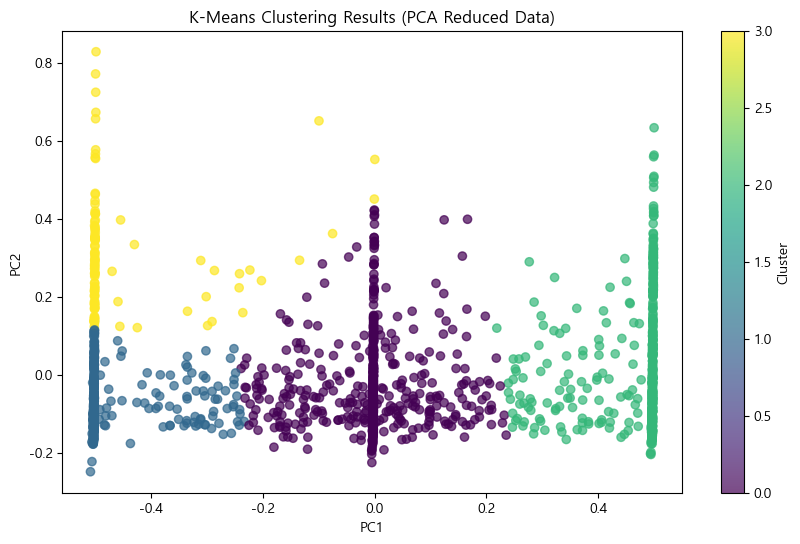

Overall Average Silhouette Score: 0.581
Cluster 0: Average Silhouette Score = 0.563
Cluster 1: Average Silhouette Score = 0.646
Cluster 2: Average Silhouette Score = 0.590
Cluster 3: Average Silhouette Score = 0.421


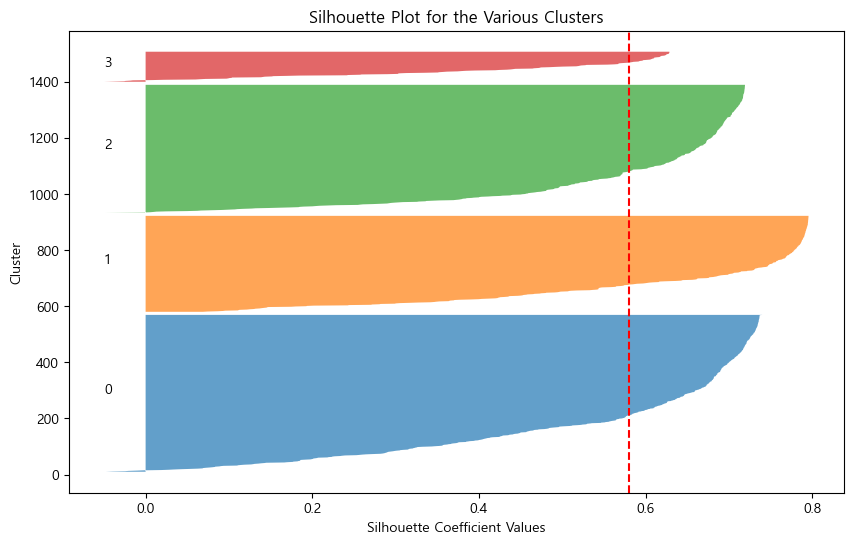


Cluster Summary (Feature Averages):
             평균할인율  Average_Unit_Price    Total_수량    쿠폰사용비율
Cluster                                                     
0        19.929409           30.827460  234.803571  0.712793
1        10.756360           21.778869  148.790087  0.801949
2        29.331807           39.321204  116.350109  0.685018
3        10.934888           98.108912   21.629630  0.465562


<Figure size 1400x800 with 0 Axes>

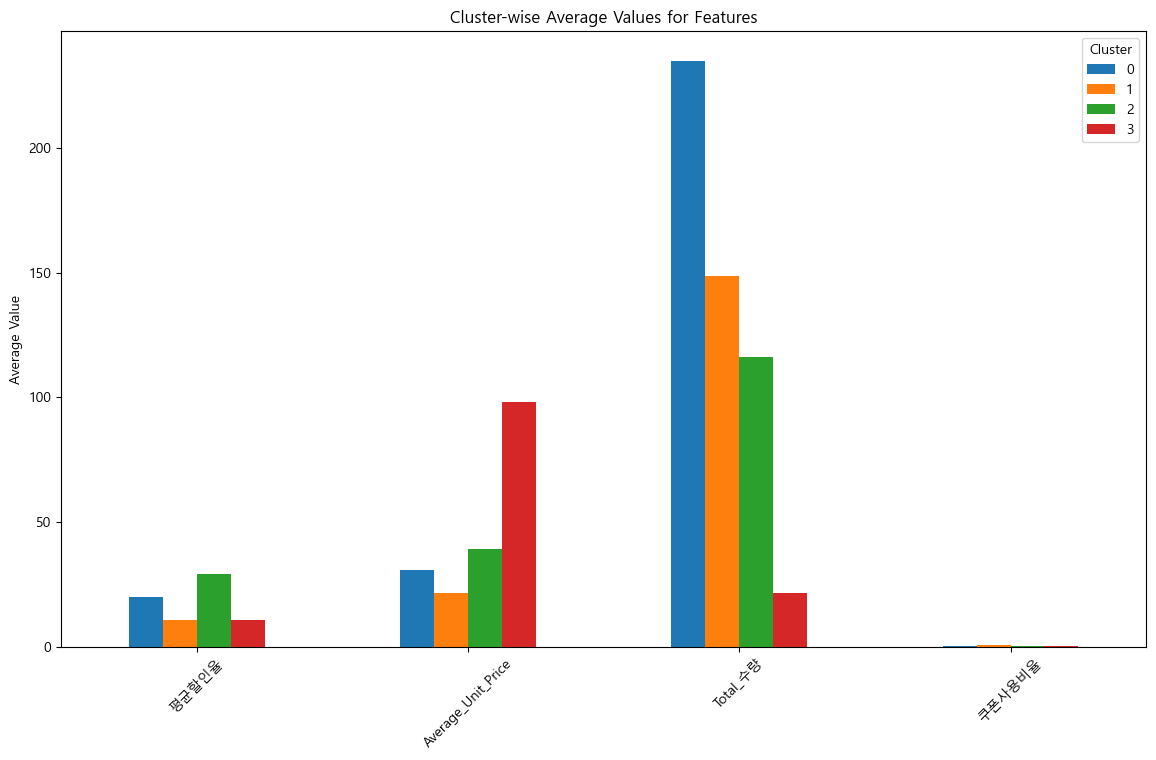

In [49]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import matplotlib.font_manager as fm  
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['font.family'] = 'Malgun Gothic' 

# 1. 데이터 로드
file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가"
df = pd.read_csv(file_path)

# 2. 숫자형 변수만 선택
data = df[['평균할인율', 'Average_Unit_Price', 'Total_수량', '쿠폰사용비율']]

# 3. 데이터 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 4. 차원 축소 (PCA)
pca = PCA(n_components=2)  # 2D로 축소
data_pca = pca.fit_transform(data_scaled)

# PCA 결과 확인
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

# 5. K‑Means 클러스터링
kmeans_model = KMeans(n_clusters=4, random_state=42)  # 클러스터 수는 4로 지정
df['Cluster'] = kmeans_model.fit_predict(data_pca)

# 클러스터 결과 확인
print("Cluster Sizes:")
print(df['Cluster'].value_counts())

# 6. 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('K-Means Clustering Results (PCA Reduced Data)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 7. 실루엣 계수 계산
if len(df['Cluster'].unique()) > 1:
    silhouette_avg = silhouette_score(data_pca, df['Cluster'])
    sample_silhouette_values = silhouette_samples(data_pca, df['Cluster'])
    print(f"Overall Average Silhouette Score: {silhouette_avg:.3f}")
    
    for cluster in np.unique(df['Cluster']):
        cluster_silhouette = sample_silhouette_values[df['Cluster'] == cluster]
        print(f"Cluster {cluster}: Average Silhouette Score = {np.mean(cluster_silhouette):.3f}")
    
    # 실루엣 계수 시각화
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(df['Cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[df['Cluster'] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette Plot for the Various Clusters")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")
    plt.show()
else:
    print("Silhouette score cannot be calculated because the number of clusters is less than 2.")

# 8. 군집별 평균값 계산
numeric_columns = data.columns  # 원본 데이터 열 이름
cluster_summary = df.groupby('Cluster')[numeric_columns].mean()

print("\nCluster Summary (Feature Averages):")
print(cluster_summary)

# 9. 군집별 평균값 시각화
plt.figure(figsize=(14, 8))
cluster_summary.T.plot(kind='bar', figsize=(14, 8))
plt.title('Cluster-wise Average Values for Features')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


In [51]:
# K-Means 클러스터링 결과가 포함된 데이터프레임을 고객 기본정보 파일에 추가
output_file = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')
